# Code for the paper "Quantum Perceptron Revisited: Computational-Statistical Tradeoffs"
The purpose of this notebook is to show how to reproduce the experimental part of the paper "Quantum Perceptron Revisited: Computational-Statistical Tradeoffs".

It contains 2 sections:
1. Implementation of Grover's search and the Quantum perceptron models
2. Simulations and figures

In [1]:
# Data management
import numpy as np
import pandas as pd
# Maths
from math import pi
import math
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
# ML
from sklearn.svm import LinearSVC
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Plot configuration
%matplotlib inline
sns.set()
sns.set_context("poster")
sns.set_style("ticks")

## 1. Implementation
### 1.1 Grover
We implement the Grover algorithm using numpy. 

We provide a function `grover` that returns an element of the dataset as if the Grover algorithm had ran on the dataset.

We provide a function `grover_opti` that returns an element of the dataset using the theoretical probability of success and assuming that every searched element has the same probability of being returned. This method will be used for one perceptron model (version space quantum perceptron) for performances purpose.

In [2]:
def get_grover_operator(classical_oracle):
    """
    Entry :
        classical_operator -> A list of booleans or integers indicating which elements are marked.
    Outputs :
        psi -> The initial state of the algorithm.
        G -> The operator coresponding to the Grover algorithm.
    """
    N = len(classical_oracle) # Number of searched elements
    
    psi = np.array([1./np.sqrt(N)]*N) # Initial state
    
    # Reflection operator U
    U = np.array([[i] for i in psi])
    U = 2.*np.dot(U,U.conj().T) - np.eye(N)
    
    # Oracle R
    R = np.eye(N)
    for i in range(len(R)):
        if classical_oracle[i]:
            R[i][i] = -1.
            
    G = np.dot(U,R)
    return psi,G

def success_proba_grover(classical_oracle,m):
    """
    Entries :
        classical oracle -> A list of booleans or integers indicating which elements are marked.
        m -> The number of steps we want to perform
    Outputs :
        steps -> A numpy array listing the steps taken by the algorithm.
        p -> A numpy array with the probability of success of the Grover algorithm for each step in steps.
    Note : The two numpy array have a len of m+1.
    """
    def success_proba(psi):
        """ Return the success probability given the current state psi. """
        s = 0.
        for i in range(len(psi)):
            if classical_oracle[i]:
                s += abs(psi[i])**2
        return s
        
    N = len(classical_oracle)
    
    psi,G = get_grover_operator(classical_oracle) # Grover inital state and operator
    steps = [0]
    p = [success_proba(psi)] # Probability of success
    
    for step in range(1,m+1):
        steps.append(step)
        psi = np.dot(G,psi)
        p.append(success_proba(psi))
        
    return np.array(steps),np.array(p)

In [3]:
def grover(classical_oracle, m):
    """
    Entries :
        classical oracle -> A list of booleans or integers indicating which elements are marked.
        m -> The number of steps we want to perform
    Output :
        Elements measured at the end of the algorithm
    """
    N = len(classical_oracle)

    psi,G = get_grover_operator(classical_oracle) # Grover inital state and operator
    psi = np.dot(np.linalg.matrix_power(G,m),psi) # Final state
    
    p = np.array([np.abs(psi[i])**2 for i in range(N)])
    c = np.random.choice(N,1,p=p) # Measurement
    return c[0]

def grover_opti(classical_oracle, m):
    """
    Entries :
        classical oracle -> A list of booleans or integers indicating which elements are marked.
        m -> The number of steps we want to perform
    Output :
        Elements measured at the end of the algorithm
    """
    N = len(classical_oracle) # Number of elements
    M = sum(classical_oracle) # Number of marked elements
    
    theta = np.arcsin(np.sqrt(M/N))
    f = lambda t:np.sin(2*theta*t+theta)**2 # Theorical probability of success
    
    p = np.array([f(m)/M if classical_oracle[i] else (1-f(m))/(N-M)  for i in range(N)])
    c = np.random.choice(N,1,p=p) # Measurement
    return c[0]

### 1.2 Perceptron algorithm

We first define the two searching procedure. One is the classical linear search and the other is the Grover quantum search.

In [4]:
def classical_search(classical_oracle):
    """
    A classical search of a marked element given an oracle.
    Entry :
         classical_oracle -> The oracle
    Output : {1},{2}
        {1} -> The element found.
        {2} -> The number of necessary steps.
    """
    for i in range(len(classical_oracle)):
        if classical_oracle[i]:
            return i,i+1
    return 0,len(classical_oracle)+1

def quantum_search(classical_oracle, nb_ampli=10, opti=False):
    """
    A quantum search of a marked element given an oracle. Several marked elements aree alowed
    Entries :
         classical_oracle -> The oracle
         nb_ampli -> Number of times we keep repeating the search if it fails.
         opti -> Wether we use the optimized version of Grover.
    Output : {1},{2}
        {1} -> The element found.
        {2} -> The number of necessary steps. This is the number of Grover steps without taking the oracle into consideration. 
    """
    N = len(classical_oracle) # Number of elements
    M = np.ceil(1./np.sin(2*np.arcsin(np.sqrt(1/N)))) # Maximal bound for the number of steps
    m = np.random.randint(0,M+1) # Number of steps is draw randomly
    x = 0 # Element found
    steps = 0 # Number of steps used
    for i in range(nb_ampli): # Each time the search failed (or the first time)
        steps+=m # Adding up the number of steps
        x = grover_opti(classical_oracle,m) if opti else grover(classical_oracle,m) # Use grover to find an element.
        if classical_oracle[x]: # If the search is a success
            break # Stop
        m = np.random.randint(0,M+1) # Else we repeat the search with a new number of steps.
        x = 0
            
    return x,steps

### The Perceptron models  
There are 3 perceptron models :
   + Perceptron_Online : Find a misclassified point, correct, then repeat.
   + Perceptron_Space : Draw random hyperplanes then find a separating one.
   + Perceptron_Hybrid : Draw random hyperplanes, then for each one, search for a misclassified point. If no misclassified point are found, this hyperplane is returned.
   
Each one of these models can be declined into it's classical and quantum version.

In [5]:
class Perceptron_Online:
    
    def __init__(self,max_iter=10000,shuffle=True,quantum=False,nb_ampli=10,opti=False):
        self.max_iter = max_iter # Number maximal of iteration
        self.shuffle = shuffle # If we shuffle the training dataset between each correction
        self.coef_ = np.array([0.]) # Default hyperplane
        self.n_iter_ = 0 # Number of iteration (include the number of steps used for the search)
        self.n_correction_ = 0 # Number of correction
        self.quantum = quantum # If we use the quantum search
        self.nb_ampli = nb_ampli # The amplification parameter for the quantum search
        self.opti=opti # If we use the opti Grover
    
    def fit(self,X,y):
        """
        Training function of the model.
        Entries :
            X -> Points
            y -> Classes
        Output :
            The number of iteration.
        The coefficient of the model will be updated during the learning.
        """
        b = True
        self.coef_ = np.array([0.]*len(X[0])) # Initialisation of the coef (can be removed if you want to train successively)
        # Copy of the entry (for the shuffle step)
        X_ = np.array([[j for j in i] for i in X])
        y_ = np.array([1 if i==1 else -1 for i in y]) # Security to ensure that the classes are {-1,1} and not {0,1}.
        
        nb=0
        while b:
            nb+=1
            if nb > self.max_iter:
                break
            b = False
            
            oracle = [int(y_[i]*X_[i,:].dot(self.coef_)<=0) for i in range(len(y_))] # Oracle for the search
            
            # The right search (according to the options) is used.
            m,steps = classical_search(oracle) if not self.quantum else quantum_search(oracle,nb_ampli=self.nb_ampli,opti=self.opti)
            self.n_iter_+=steps # We add the number of steps to the model

            if y_[m]*X_[m,:].dot(self.coef_)<=0: # If the search is successful we correct
                self.coef_ = self.coef_ + y_[m]*X_[m,:]
                b = True
                self.n_correction_+=1
                nb+=1
            
            
            if self.shuffle: # Shufffle
                l = list(range(len(X)))
                np.random.shuffle(l)
                X_ = np.array([X[i] for i in l])
                y_ = np.array([1 if y[i]==1 else -1 for i in l])
        return self.n_iter_
    
    def predict(self,X):
        """
        Entry : Points
        Output : Classification
        """
        return np.array([1 if x.dot(self.coef_)>0 else -1 for x in X])

In [6]:
class Perceptron_Space:
    def __init__(self,separators,nb_ampli=10,quantum=False,opti=False):
        self.separators = separators # Set of separators
        np.random.shuffle(self.separators)
        self.selected = 0 # The selected separator
        self.n_iter_=0 # Number of steps
        self.coef_ = self.separators[self.selected] # Default hyperplane
        self.quantum = quantum # If we use the quantum search
        self.nb_ampli = nb_ampli # The amplification parameter for the quantum search
        self.opti=opti # If we use the opti Grover
    
    def fit(self,X,y):
        """
        Training function of the model.
        Entries :
            X -> Points
            y -> Classes
        Output :
            The number of iteration.
        One of the "separators" will be chosen. 
        """
        X_ = np.array([[j for j in i] for i in X])
        y_ = np.array([1 if i==1 else -1 for i in y]) # Security to ensure that the classes are {-1,1} and not {0,1}.
        
        # Oracle over the hyerplanes
        oracle = [int(all([y_[i]*X_[i,:].dot(self.separators[k])>0 for i in range(len(X_))])) for k in range(len(self.separators))]
        
        # Search
        k,steps = classical_search(oracle) if not self.quantum else quantum_search(oracle,nb_ampli=self.nb_ampli,opti=self.opti)
        
        self.n_iter_+=steps*len(X_) # The number of steps is multiplied by the comlexity of the oracle.
        if all([y_[i]*X_[i,:].dot(self.separators[k])>0 for i in range(len(X_))]): # If the search is successful we take the hyperplane.
                self.selected = k
                self.coef_ = self.separators[self.selected]
        
        return self.n_iter_
    
    def predict(self,X):
        """
        Entry : Points
        Output : Classification
        """
        return np.array([1 if x.dot(self.separators[self.selected])>0 else -1 for x in X])

In [7]:
class Perceptron_Hybrid:
    def __init__(self,separators,nb_ampli=10,quantum=False,opti=False):
        self.separators = separators # Set of separators
        np.random.shuffle(self.separators)
        self.selected = 0 # The selected separator
        self.n_iter_=0 # Number of steps
        self.coef_ = self.separators[self.selected] # Default hyperplane
        self.quantum = quantum # If we use the quantum search
        self.nb_ampli = nb_ampli # The amplification parameter for the quantum search
        self.opti=opti # If we use the opti Grover
    
    def fit(self,X,y):
        """
        Training function of the model.
        Entries :
            X -> Points
            y -> Classes
        Output :
            The number of iteration.
        One of the "separators" will be chosen. 
        """
        X_ = np.array([[j for j in i] for i in X])
        y_ = np.array([1 if i==1 else -1 for i in y]) # Security to ensure that the classes are {-1,1} and not {0,1}.
        
        for k in range(len(self.separators)): # For each separators
            # Oracle over the points
            oracle = [int(y_[i]*X_[i,:].dot(self.separators[k])<=0) for i in range(len(y_))]
            # Search
            m,steps = classical_search(oracle) if not self.quantum else quantum_search(oracle,nb_ampli=self.nb_ampli,opti=self.opti)
        
            self.n_iter_+=steps
        
            if y_[m]*X_[m,:].dot(self.separators[k])>0: # If successful we chose this hyperplane
                    self.selected = k
                    self.coef_ = self.separators[self.selected]
                    break
        
        return self.n_iter_
    
    def predict(self,X):
        """
        Entry : Points
        Output : Classification
        """
        return np.array([1 if x.dot(self.separators[self.selected])>0 else -1 for x in X])

## 2. Simulations and figures
### 2.1 Dataset
We load the Iris dataset, build up the Hard dataset and define some tools for the simulation.

In [8]:
model_name=["Online perceptron", "Version space perceptron", "Version space quantum perceptron", "Online quantum perceptron", "Hybrid quantum perceptron"]

def init_model(name,X,gamma=0.01,eps=0.01):
    """
    This function's purpose is to initalize the models with the right parameters (epsilon, gamma, ...).
    Entries :
        name -> Name of the model (as listed in model_name)
        X -> The points (the margin, dimension and number of point are used in order to precise the best parameter)
        gamma -> If you want to specify the margin yourself. Useful when the margin is very small and the computation very long.
        eps -> The mistake parameter when chosing the number of hyperplanes and amplifying the quantum search's probability of success
    Output :
        A model with the coresponding parameters.
    Note : The version space quantum algorithm uses the optimmized version of Grover by default because it's the slowest.
    It's here if you want to change this.
    """
    len_data = len(X[0])
    if name==model_name[0]: # Classical perceptron
        return Perceptron_Online(max_iter=int(len(X)/gamma**2),shuffle=False)

    if name==model_name[1]: # Version space classical perceptron
        nb_hyperplanes = math.ceil(math.log(eps)/math.log(1-math.sqrt(2/pi)*gamma))
        separators = np.random.multivariate_normal([0]*len_data,np.eye(len_data),size=nb_hyperplanes)
        return Perceptron_Space(separators)

    if name==model_name[2]: # Version space quantum perceptron
        nb_hyperplanes = math.ceil(np.log(eps)/np.log(1-np.sqrt(2/pi)*gamma))
        nb_ampli = math.ceil(np.log(eps)/np.log(3/4))
        separators = np.random.multivariate_normal([0]*len_data,np.eye(len_data),size=nb_hyperplanes)
        return Perceptron_Space(separators, nb_ampli=nb_ampli, quantum=True, opti=True) # Optimization here

    if name==model_name[3]: # Online quantum perceptron
        nb_ampli = math.ceil(np.log(eps*gamma**2)/np.log(3/4))
        return Perceptron_Online(max_iter=int(len(X)/gamma**2), nb_ampli=nb_ampli, shuffle=False, quantum=True)

    if name==model_name[4]: # Hybrid quantum perceptron
        nb_hyperplanes = math.ceil(np.log(eps/2)/np.log(1-np.sqrt(2/pi)*gamma))
        nb_ampli = math.ceil(np.log(1-(1-eps/2)**(1/(nb_hyperplanes-1)))/np.log(3/4))
        separators = np.random.multivariate_normal([0]*len_data,np.eye(len_data),size=nb_hyperplanes)
        return Perceptron_Hybrid(separators, nb_ampli=nb_ampli, quantum=True)

In [9]:
def compute_margin(X,y,fit_intercept=False):
    """
    Use SVM of sklearn to compute the margin of a dataset.
    Entries :
        X -> The points
        y -> The classes
        fit_intercept -> If you want to allow the intercept to be fitted. The model coded here haven't this option.
    Outputs :
        w -> The best separator / the most centered one / the on that realizes the margin.
        b -> The intercept
        gamma -> The margin
    """
    y = [1 if i==1 else -1 for i in y]
    clf = LinearSVC(fit_intercept=fit_intercept,max_iter=100000)
    clf.fit(X, y)
    w = clf.coef_[0]
    b=0
    if fit_intercept:
        b = clf.intercept_[0]
    gamma = min([y[i]*(X[i,:].dot(w)+b)/np.linalg.norm(w) for i in range(len(X))])
    w = w/np.linalg.norm(w)
    return w,b,gamma

In [10]:
def get_iris():
    """
    Load Iris with some restrictions.
    """
    iris = datasets.load_iris()
    X_ = iris.data[:,:2]
    Y_ = iris.target
    X = np.array([X_[i]+np.array([0,3.3]) for i in range(len(X_)) if Y_[i] != 2])
    y = np.array([1 if i==0 else -1 for i in Y_ if i != 2])
    size_max = max([np.sqrt(sum(x**2)) for x in X])
    X = np.array([[i/size_max for i in x] for x in X])
    
    u = sum(X)/len(X)
    X = X-u + np.array([0.013,0.])
    
    return X,y

In [11]:
def get_hard(N=200):
    X = []
    for i in range(0,N):
        X.append([(0)**i if j<i else ((-1)**(i+1) if i==j else 0) for j in range(N)])
    y = np.array([1 if i%2==0 else -1 for i in range(N)])
    X = np.array(X)
    return X,y

### 2.2 Simulation procedure
Below is the simulation procedure to get the score for a specific perceptron model and a specific dataset.

In [12]:
def simul(X,y,eps=0.01,train_size=0.66,m=100,gamma=None):
    """
    This function train each models m times and get the mean of the score and number of steps.
    Entries : 
        X -> The points
        y -> The classes
        eps -> The amplification parameter
        train_size -> ratio of the dataset used for training.
        m -> Number of times the process is repeated befor looking at the mean.
        gamma -> If we want to specify the value of gamma.
    Outputs : Panda Dataframe
        algo -> The model used
        N -> The size of the dataset
        gamma -> The margin of the dataset
        train_size -> The ratio of the dataset used for training.
        score -> The proportion of points of the testing dataset that are correctly classified after training.
        nb_operation -> The number of steps used by the algorithm (include the steps for the search and the cost of the oracle).
    """
    if gamma==None:
        _,_,gamma = compute_margin(X,y,fit_intercept=False)
    len_data = len(X[0])
    ret = []
    
    progress = 0
    print("\r{}%     ".format(100*progress/(m*len(model_name))),end="")
    for name in model_name[:]:
        score=0
        nb_iter = 0
        for i in range(m):
            model = init_model(name,X,gamma=gamma)
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
            while not(-1 in y_train and 1 in y_train and -1 in y_test and 1 in y_test):
                X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
            model.fit(X_train,y_train)
            nb_iter += model.n_iter_
            score += np.mean([int(z==y) for z,y in zip(model.predict(X_test),y_test)])
            
            progress+=1
            print("\r{}%     ".format(100*progress/(m*len(model_name))),end="")
            
        score/=m
        nb_iter/=m
        ret.append([name,len(X),gamma,train_size,score,nb_iter])
        
    print("\rdone    ")
    return pd.DataFrame(np.array(ret,dtype=object),
                        columns=["algo","N","gamma","train_size","score","nb_operations"])

### 2.3 Simulations
Now we run the simulations for both dataset and all the perceptron models.

**Iris Dataset :**

In [13]:
X,y = get_iris()
np.random.seed(1) # To ensure reproductibility
res_iris = simul(X,y,m=10,train_size=0.1)
res_iris["dataset"] = "Iris"
res_iris

done    


,algo,N,gamma,train_size,score,nb_operations,dataset
0,Online perceptron,100,0.011011,0.1,0.981111,21.0,Iris
1,Version space perceptron,100,0.011011,0.1,0.967778,120.0,Iris
2,Version space quantum perceptron,100,0.011011,0.1,0.975556,128.0,Iris
3,Online quantum perceptron,100,0.011011,0.1,0.983333,50.0,Iris
4,Hybrid quantum perceptron,100,0.011011,0.1,0.956667,65.2,Iris


**Hard Dataset (a few minutes are required) :**

In [14]:
X,y = get_hard()
np.random.seed(1) # To ensure reproductibility
res_th = simul(X,y,m=10,eps=0.01,train_size=0.9)
res_th["dataset"] = "Hard"
res_th

done    


,algo,N,gamma,train_size,score,nb_operations,dataset
0,Online perceptron,200,0.070711,0.9,0.54,16471.0,Hard
1,Version space perceptron,200,0.070711,0.9,0.55,14580.0,Hard
2,Version space quantum perceptron,200,0.070711,0.9,0.54,8298.0,Hard
3,Online quantum perceptron,200,0.070711,0.9,0.485,1397.3,Hard
4,Hybrid quantum perceptron,200,0.070711,0.9,0.515,653.8,Hard


### 2.4 Results
Here we show the results of the previous simulations. This shows how to produce Figure 2 of the paper.

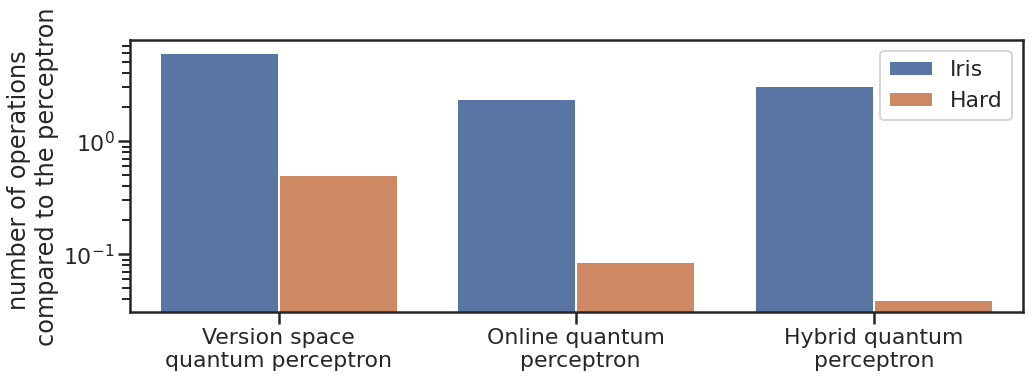

In [15]:
plt.figure(figsize=(16,5))

names = ["Classical\nperceptron","Version space\nperceptron",
        "Version space\nquantum perceptron","Online quantum\n perceptron","Hybrid quantum\nperceptron"]

res_iris["nb_operations"]/=res_iris["nb_operations"][0]
res_iris["algo"] = names
res_iris["dataset"] = "Iris"

res_th["nb_operations"]/=res_th["nb_operations"][0]
res_th["algo"] = names
res_th["dataset"] = "Hard"


res_final = pd.concat([res_iris,res_th])
res_final = res_final[res_final["algo"] != names[0]]
res_final = res_final[res_final["algo"] != names[1]]

sns.barplot(x="algo",y="nb_operations",hue="dataset",data=res_final)
plt.xlabel("")
plt.ylabel("number of operations \ncompared to the perceptron")
plt.yscale("log")
plt.legend()